### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

#from icecream import ic 

# for plotting graphs
import matplotlib.pyplot as plt


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
from Env import CabDriver
env=CabDriver()
action_space, state_space, state = env.reset()
action_size = len(env.action_space)


In [4]:
Time_matrix.shape

(5, 5, 24, 7)

In [5]:
Time_matrix[0]

array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 

In [6]:
Time_matrix[2][1][12][2]

1.0

In [7]:
np.random.poisson(12)

5

#### Tracking the state-action pairs for checking convergence


In [8]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01  
        self.epsilon_max = 1
        self.epsilon_decay = -0.005 
        self.epsilon_min = 0.000001
        self.epsilon = 1
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        self.states_tracked=[]
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
                
        model.add(Dense(50, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(50, activation='relu', kernel_initializer='he_uniform'))
        
        # the output layer: output is of size num_actions
        
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, act_idx):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment  
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            return random.choice(act_idx)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1,36)
            q_value = self.model.predict(state)
            # check for q values whose requests are possible on given day and time
            avail_q=[q_value[0][k] for k in act_idx]
            return act_idx[np.argmax(avail_q)] 
        
    def append_sample(self, state, action, reward, next_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            #[(s,a,r,s'),(s,a,r,s') .... ]
            update_output = np.zeros((self.batch_size,self.state_size))# write here
            update_input = np.zeros((self.batch_size,self.state_size))# write here
            actions, rewards = [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                
                actions.append(action)
                rewards.append(reward)
                
                # Write your code from here
                # 1.  Update your 'update_output' and 'update_input' batch
                update_input[i] = env.state_encod_arch1(state)
                update_output[i] = env.state_encod_arch1(next_state)

            q_vals = self.model.predict(update_output) ## (batchsize,len(action_space))
            target = self.model.predict(update_input)
            
            for i in range(self.batch_size):
                target[i][actions[i]] = rewards[i]+self.discount_factor*max(q_vals[i])
            # 4. Fit your model and track the loss values

            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0 )
            
    def save_tracking_states(self):
        
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save(self, name):
        self.model.save(name)
        
    def save_pbj(self, name):
        with open(name + '.pkl', 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)      

In [10]:
Episodes = 5000
episode_time = 24*30
episode_time

720

In [11]:
start_time = time.time()
state_size = 36 # m + t + d value
action_size = len(env.action_space)

agent = DQNAgent(state_size, action_size)

rewards_per_episode, episodes = [], []
reward_initial_stat=[]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### DQN block

In [12]:

for episode in range(Episodes):

    
    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    #Call the DQN agent
    
    total_time=0
    terminal_state = False
    env = CabDriver()
    action_space, state_space, state = env.reset()
    
    # Saving the initial state such that Reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init
    
    count=0
    total_reward = 0
    while not terminal_state:
        count+=1
        possible_actions_index,actions=env.requests(state)
        action = agent.get_action(state, possible_actions_index)
        reward = env.reward_func(state,env.action_space[action], Time_matrix)
        next_state,total_time_elapsed = env.next_state_func(state, env.action_space[action], Time_matrix)
        
        total_time += total_time_elapsed
        
        if total_time > episode_time:
            terminal_state=True
        else:
            pass

        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
                
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state)
        
        total_reward += reward
        state = next_state
            
        if count%20 == 0:
            # 4. Train the model by calling function agent.train_model
            # 5. Keep a track of rewards, Q-values, loss
            agent.train_model()
            
    rewards_per_episode.append(total_reward) 
    episodes.append(episode)
    #Epsilon value based on epsilon decay rate , new epsilon value is getting assigned to Agent object of DQNAgent class
    agent.epsilon = (1 - 0.0001) * np.exp(agent.epsilon_decay * episode)
    
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         total_reward,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    if ((episode + 1) % 5 == 0):            
            agent.save_tracking_states()
    
    if (episode%10 ==0):
        #saving model and weights every 100th episode
        print("Saving Model {}".format(episode))
        agent.model.save_weights("model_weights.h5")
        agent.save(name="model_weights.pkl")

elapsed_time = time.time() - start_time
print(elapsed_time)

episode 0, reward -77.0, memory_length 135, epsilon 0.9999 total_time 721.0
Saving Model 0
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 1, reward 171.0, memory_length 301, epsilon 0.9949129779447631 total_time 722.0
episode 2, reward -73.0, memory_length 437, epsilon 0.9899508287657932 total_time 726.0
episode 3, reward -67.0, memory_length 570, epsilon 0.9850134284091023 total_time 721.0
episode 4, reward -167.0, memory_length 702, epsilon 0.9801006534394245 total_time 734.0
episode 5, reward -43.0, memory_length 834, epsilon 0.9752123810371298 total_time 724.0
episode 6, reward 59.0, memory_length 960, epsilon 0.9703484889951534 total_time 728.0
episode 7, reward -88.0, memory_length 1087, epsilon 0.9655088557159407 total_time 731.0
episode 8, reward -27.0, memory_length 1222, epsilon 0.960693360208408 total_time 721.0
episode 9, reward -32.0, memory_length 1355, epsilon 0.9559018820849167 total_time 725.0
episode 10, reward -245.0, memory_length 1475, epsilon 

episode 84, reward 240.0, memory_length 2000, epsilon 0.6569811151330752 total_time 729.0
episode 85, reward 137.0, memory_length 2000, epsilon 0.6537044081513343 total_time 725.0
episode 86, reward 340.0, memory_length 2000, epsilon 0.6504440438138442 total_time 728.0
episode 87, reward 3.0, memory_length 2000, epsilon 0.6471999406113269 total_time 730.0
episode 88, reward 391.0, memory_length 2000, epsilon 0.643972017441033 total_time 725.0
episode 89, reward 24.0, memory_length 2000, epsilon 0.6407601936047155 total_time 722.0
episode 90, reward 14.0, memory_length 2000, epsilon 0.6375643888066111 total_time 724.0
Saving Model 90
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 91, reward 174.0, memory_length 2000, epsilon 0.6343845231514335 total_time 732.0
episode 92, reward 378.0, memory_length 2000, epsilon 0.6312205171423753 total_time 724.0
episode 93, reward 26.0, memory_length 2000, epsilon 0.6280722916791218 total_time 729.0
episode 94, reward -44.0, memo

episode 168, reward 257.0, memory_length 2000, epsilon 0.4316673523767368 total_time 727.0
episode 169, reward 267.0, memory_length 2000, epsilon 0.42951440247491807 total_time 722.0
episode 170, reward 220.0, memory_length 2000, epsilon 0.4273721904555318 total_time 727.0
Saving Model 170
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 171, reward 405.0, memory_length 2000, epsilon 0.4252406627631659 total_time 721.0
episode 172, reward 673.0, memory_length 2000, epsilon 0.42311976610951707 total_time 728.0
episode 173, reward 244.0, memory_length 2000, epsilon 0.4210094474720585 total_time 726.0
episode 174, reward 422.0, memory_length 2000, epsilon 0.41890965409271425 total_time 727.0
episode 175, reward 528.0, memory_length 2000, epsilon 0.4168203334765405 total_time 723.0
episode 176, reward 339.0, memory_length 2000, epsilon 0.41474143339041325 total_time 726.0
episode 177, reward 257.0, memory_length 2000, epsilon 0.4126729018617218 total_time 722.0
episode 1

INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 251, reward 382.0, memory_length 2000, epsilon 0.2850473406396311 total_time 724.0
episode 252, reward 517.0, memory_length 2000, epsilon 0.2836256610971204 total_time 728.0
episode 253, reward 469.0, memory_length 2000, epsilon 0.28221107221090924 total_time 721.0
episode 254, reward 446.0, memory_length 2000, epsilon 0.28080353861620194 total_time 722.0
episode 255, reward 752.0, memory_length 2000, epsilon 0.27940302512458515 total_time 723.0
episode 256, reward 596.0, memory_length 2000, epsilon 0.27800949672314884 total_time 729.0
episode 257, reward 218.0, memory_length 2000, epsilon 0.2766229185736102 total_time 721.0
episode 258, reward 699.0, memory_length 2000, epsilon 0.27524325601144334 total_time 724.0
episode 259, reward 598.0, memory_length 2000, epsilon 0.27387047454501245 total_time 727.0
episode 260, reward 392.0, memory_length 2000, epsilon 0.2725045398547092 total_time 721.0
Saving Model 260
INFO:te

episode 334, reward 851.0, memory_length 2000, epsilon 0.18822824093218293 total_time 724.0
episode 335, reward 517.0, memory_length 2000, epsilon 0.18728944866400882 total_time 728.0
episode 336, reward 715.0, memory_length 2000, epsilon 0.18635533864180603 total_time 735.0
episode 337, reward 246.0, memory_length 2000, epsilon 0.18542588751277528 total_time 725.0
episode 338, reward 786.0, memory_length 2000, epsilon 0.18450107204058996 total_time 724.0
episode 339, reward 891.0, memory_length 2000, epsilon 0.18358086910481508 total_time 724.0
episode 340, reward 823.0, memory_length 2000, epsilon 0.1826652557003294 total_time 731.0
Saving Model 340
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 341, reward 594.0, memory_length 2000, epsilon 0.18175420893674998 total_time 728.0
episode 342, reward 697.0, memory_length 2000, epsilon 0.18084770603786038 total_time 728.0
episode 343, reward 458.0, memory_length 2000, epsilon 0.17994572434104086 total_time 723.0
epis

episode 417, reward 829.0, memory_length 2000, epsilon 0.1242946894537628 total_time 724.0
episode 418, reward 657.0, memory_length 2000, epsilon 0.12367476710387308 total_time 728.0
episode 419, reward 780.0, memory_length 2000, epsilon 0.12305793662960231 total_time 722.0
episode 420, reward 970.0, memory_length 2000, epsilon 0.1224441826101566 total_time 726.0
Saving Model 420
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 421, reward 723.0, memory_length 2000, epsilon 0.12183348970165345 total_time 721.0
episode 422, reward 995.0, memory_length 2000, epsilon 0.12122584263673834 total_time 725.0
episode 423, reward 865.0, memory_length 2000, epsilon 0.12062122622420295 total_time 724.0
episode 424, reward 515.0, memory_length 2000, epsilon 0.12001962534860558 total_time 734.0
episode 425, reward 281.0, memory_length 2000, epsilon 0.11942102496989294 total_time 726.0
episode 426, reward 878.0, memory_length 2000, epsilon 0.11882541012302442 total_time 726.0
episo

episode 500, reward 337.0, memory_length 2000, epsilon 0.08207679012403642 total_time 721.0
Saving Model 500
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 501, reward 820.0, memory_length 2000, epsilon 0.08166743042549493 total_time 724.0
episode 502, reward 723.0, memory_length 2000, epsilon 0.08126011241696758 total_time 724.0
episode 503, reward 783.0, memory_length 2000, epsilon 0.080854825915483 total_time 724.0
episode 504, reward 911.0, memory_length 2000, epsilon 0.08045156078885748 total_time 725.0
episode 505, reward 850.0, memory_length 2000, epsilon 0.08005030695544187 total_time 721.0
episode 506, reward 615.0, memory_length 2000, epsilon 0.07965105438386942 total_time 721.0
episode 507, reward 886.0, memory_length 2000, epsilon 0.07925379309280507 total_time 724.0
episode 508, reward 1074.0, memory_length 2000, epsilon 0.07885851315069588 total_time 722.0
episode 509, reward 593.0, memory_length 2000, epsilon 0.07846520467552266 total_time 722.0
epis

episode 582, reward 1135.0, memory_length 2000, epsilon 0.05447028229620294 total_time 724.0
episode 583, reward 974.0, memory_length 2000, epsilon 0.054198610629870164 total_time 723.0
episode 584, reward 977.0, memory_length 2000, epsilon 0.05392829393162599 total_time 722.0
episode 585, reward 674.0, memory_length 2000, epsilon 0.05365932544353883 total_time 728.0
episode 586, reward 1090.0, memory_length 2000, epsilon 0.053391698441382564 total_time 726.0
episode 587, reward 985.0, memory_length 2000, epsilon 0.05312540623446814 total_time 723.0
episode 588, reward 969.0, memory_length 2000, epsilon 0.052860442165476536 total_time 723.0
episode 589, reward 1071.0, memory_length 2000, epsilon 0.05259679961029221 total_time 723.0
episode 590, reward 1023.0, memory_length 2000, epsilon 0.05233447197783754 total_time 738.0
Saving Model 590
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 591, reward 428.0, memory_length 2000, epsilon 0.0520734527099081 total_time 729

episode 664, reward 878.0, memory_length 2000, epsilon 0.03614921647087101 total_time 722.0
episode 665, reward 863.0, memory_length 2000, epsilon 0.03596892150155431 total_time 722.0
episode 666, reward 629.0, memory_length 2000, epsilon 0.035789525757148534 total_time 723.0
episode 667, reward 827.0, memory_length 2000, epsilon 0.03561102475275072 total_time 725.0
episode 668, reward 1195.0, memory_length 2000, epsilon 0.03543341402582648 total_time 731.0
episode 669, reward 1038.0, memory_length 2000, epsilon 0.03525668913609836 total_time 729.0
episode 670, reward 979.0, memory_length 2000, epsilon 0.03508084566543494 total_time 722.0
Saving Model 670
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 671, reward 884.0, memory_length 2000, epsilon 0.034905879217740285 total_time 722.0
episode 672, reward 688.0, memory_length 2000, epsilon 0.03473178541884409 total_time 725.0
episode 673, reward 797.0, memory_length 2000, epsilon 0.0345585599163923 total_time 725.0


episode 746, reward 934.0, memory_length 2000, epsilon 0.023990436553125504 total_time 734.0
episode 747, reward 701.0, memory_length 2000, epsilon 0.02387078375164016 total_time 730.0
episode 748, reward 1069.0, memory_length 2000, epsilon 0.023751727720991867 total_time 721.0
episode 749, reward 640.0, memory_length 2000, epsilon 0.023633265484773677 total_time 722.0
episode 750, reward 858.0, memory_length 2000, epsilon 0.023515394081423505 total_time 721.0
Saving Model 750
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 751, reward 1048.0, memory_length 2000, epsilon 0.023398110564150136 total_time 722.0
episode 752, reward 834.0, memory_length 2000, epsilon 0.02328141200085951 total_time 729.0
episode 753, reward 753.0, memory_length 2000, epsilon 0.02316529547408149 total_time 722.0
episode 754, reward 1001.0, memory_length 2000, epsilon 0.02304975808089685 total_time 730.0
episode 755, reward 1545.0, memory_length 2000, epsilon 0.022934796932864737 total_time

episode 828, reward 978.0, memory_length 2000, epsilon 0.015921259219361248 total_time 732.0
episode 829, reward 802.0, memory_length 2000, epsilon 0.01584185160772597 total_time 727.0
episode 830, reward 1169.0, memory_length 2000, epsilon 0.015762840043206 total_time 724.0
Saving Model 830
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 831, reward 1141.0, memory_length 2000, epsilon 0.01568422255050809 total_time 727.0
episode 832, reward 1046.0, memory_length 2000, epsilon 0.015605997164190833 total_time 722.0
episode 833, reward 650.0, memory_length 2000, epsilon 0.015528161928615492 total_time 721.0
episode 834, reward 773.0, memory_length 2000, epsilon 0.015450714897897124 total_time 721.0
episode 835, reward 1028.0, memory_length 2000, epsilon 0.015373654135855931 total_time 727.0
episode 836, reward 818.0, memory_length 2000, epsilon 0.015296977715968847 total_time 724.0
episode 837, reward 1017.0, memory_length 2000, epsilon 0.015220683721321366 total_time

episode 910, reward 1228.0, memory_length 2000, epsilon 0.01056614766341427 total_time 730.0
Saving Model 910
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 911, reward 272.0, memory_length 2000, epsilon 0.0105134487820898 total_time 722.0
episode 912, reward 832.0, memory_length 2000, epsilon 0.010461012737532452 total_time 729.0
episode 913, reward 936.0, memory_length 2000, epsilon 0.010408838218838394 total_time 722.0
episode 914, reward 804.0, memory_length 2000, epsilon 0.010356923921641935 total_time 726.0
episode 915, reward 790.0, memory_length 2000, epsilon 0.010305268548082941 total_time 723.0
episode 916, reward 584.0, memory_length 2000, epsilon 0.010253870806774382 total_time 728.0
episode 917, reward 1075.0, memory_length 2000, epsilon 0.010202729412770048 total_time 728.0
episode 918, reward 1023.0, memory_length 2000, epsilon 0.010151843087532426 total_time 730.0
episode 919, reward 1080.0, memory_length 2000, epsilon 0.010101210558900736 total_tim

episode 991, reward 1001.0, memory_length 2000, epsilon 0.007047375471603769 total_time 723.0
episode 992, reward 1195.0, memory_length 2000, epsilon 0.007012226539802166 total_time 722.0
episode 993, reward 1229.0, memory_length 2000, epsilon 0.006977252914029277 total_time 727.0
episode 994, reward 822.0, memory_length 2000, epsilon 0.00694245371994264 total_time 724.0
episode 995, reward 1110.0, memory_length 2000, epsilon 0.00690782808756058 total_time 721.0
episode 996, reward 1195.0, memory_length 2000, epsilon 0.006873375151240499 total_time 721.0
episode 997, reward 702.0, memory_length 2000, epsilon 0.006839094049657187 total_time 727.0
episode 998, reward 630.0, memory_length 2000, epsilon 0.00680498392578132 total_time 726.0
episode 999, reward 618.0, memory_length 2000, epsilon 0.006771043926858024 total_time 731.0
episode 1000, reward 1003.0, memory_length 2000, epsilon 0.006737273204385558 total_time 722.0
Saving Model 1000
INFO:tensorflow:Assets written to: model_weights

episode 1072, reward 428.0, memory_length 2000, epsilon 0.004700436016972518 total_time 722.0
episode 1073, reward 733.0, memory_length 2000, epsilon 0.004676992494534403 total_time 727.0
episode 1074, reward 346.0, memory_length 2000, epsilon 0.0046536658971522435 total_time 721.0
episode 1075, reward 1033.0, memory_length 2000, epsilon 0.004630455641659892 total_time 730.0
episode 1076, reward 955.0, memory_length 2000, epsilon 0.004607361147799752 total_time 725.0
episode 1077, reward 677.0, memory_length 2000, epsilon 0.004584381838208275 total_time 722.0
episode 1078, reward 728.0, memory_length 2000, epsilon 0.004561517138401523 total_time 721.0
episode 1079, reward 362.0, memory_length 2000, epsilon 0.004538766476760805 total_time 722.0
episode 1080, reward 753.0, memory_length 2000, epsilon 0.004516129284518404 total_time 726.0
Saving Model 1080
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 1081, reward 901.0, memory_length 2000, epsilon 0.0044936049957433

episode 1153, reward 525.0, memory_length 2000, epsilon 0.003135081824244642 total_time 731.0
episode 1154, reward 903.0, memory_length 2000, epsilon 0.0031194455384135756 total_time 729.0
episode 1155, reward 661.0, memory_length 2000, epsilon 0.003103887238883444 total_time 723.0
episode 1156, reward 796.0, memory_length 2000, epsilon 0.003088406536695945 total_time 726.0
episode 1157, reward 1032.0, memory_length 2000, epsilon 0.0030730030448327186 total_time 723.0
episode 1158, reward 658.0, memory_length 2000, epsilon 0.003057676378205665 total_time 725.0
episode 1159, reward 720.0, memory_length 2000, epsilon 0.003042426153647321 total_time 721.0
episode 1160, reward 619.0, memory_length 2000, epsilon 0.0030272519899012776 total_time 723.0
Saving Model 1160
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 1161, reward 803.0, memory_length 2000, epsilon 0.0030121535076126516 total_time 736.0
episode 1162, reward 1152.0, memory_length 2000, epsilon 0.002997130329

episode 1233, reward 833.0, memory_length 2000, epsilon 0.002101508192753164 total_time 723.0
episode 1234, reward 788.0, memory_length 2000, epsilon 0.002091026876915059 total_time 722.0
episode 1235, reward 994.0, memory_length 2000, epsilon 0.0020805978368577845 total_time 723.0
episode 1236, reward 949.0, memory_length 2000, epsilon 0.0020702208118547967 total_time 724.0
episode 1237, reward 499.0, memory_length 2000, epsilon 0.0020598955424799273 total_time 728.0
episode 1238, reward 333.0, memory_length 2000, epsilon 0.0020496217706009075 total_time 723.0
episode 1239, reward 296.0, memory_length 2000, epsilon 0.0020393992393729046 total_time 723.0
episode 1240, reward 276.0, memory_length 2000, epsilon 0.0020292276932321043 total_time 722.0
Saving Model 1240
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 1241, reward 517.0, memory_length 2000, epsilon 0.0020191068778893243 total_time 721.0
episode 1242, reward 688.0, memory_length 2000, epsilon 0.00200903654

episode 1313, reward 1045.0, memory_length 2000, epsilon 0.001408683068510573 total_time 722.0
episode 1314, reward 866.0, memory_length 2000, epsilon 0.0014016572323954607 total_time 734.0
episode 1315, reward 1101.0, memory_length 2000, epsilon 0.0013946664377841613 total_time 725.0
episode 1316, reward 422.0, memory_length 2000, epsilon 0.0013877105099064453 total_time 721.0
episode 1317, reward 1126.0, memory_length 2000, epsilon 0.0013807892748637534 total_time 721.0
episode 1318, reward 575.0, memory_length 2000, epsilon 0.0013739025596248497 total_time 726.0
episode 1319, reward 694.0, memory_length 2000, epsilon 0.0013670501920214938 total_time 727.0
episode 1320, reward 990.0, memory_length 2000, epsilon 0.001360232000744138 total_time 726.0
Saving Model 1320
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 1321, reward 993.0, memory_length 2000, epsilon 0.0013534478153376475 total_time 722.0
episode 1322, reward 946.0, memory_length 2000, epsilon 0.00134669

episode 1393, reward 629.0, memory_length 2000, epsilon 0.0009442684993336335 total_time 731.0
episode 1394, reward 1015.0, memory_length 2000, epsilon 0.0009395589405455125 total_time 724.0
episode 1395, reward 550.0, memory_length 2000, epsilon 0.0009348728707798397 total_time 727.0
episode 1396, reward 650.0, memory_length 2000, epsilon 0.0009302101728846285 total_time 722.0
episode 1397, reward 960.0, memory_length 2000, epsilon 0.000925570730292188 total_time 723.0
episode 1398, reward 1097.0, memory_length 2000, epsilon 0.0009209544270162115 total_time 722.0
episode 1399, reward 652.0, memory_length 2000, epsilon 0.0009163611476488769 total_time 722.0
episode 1400, reward 936.0, memory_length 2000, epsilon 0.0009117907773579608 total_time 726.0
Saving Model 1400
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 1401, reward 838.0, memory_length 2000, epsilon 0.0009072432018839676 total_time 725.0
episode 1402, reward 963.0, memory_length 2000, epsilon 0.00090271

episode 1473, reward 1130.0, memory_length 2000, epsilon 0.0006329621039433251 total_time 721.0
episode 1474, reward 951.0, memory_length 2000, epsilon 0.0006298051922796643 total_time 726.0
episode 1475, reward 1281.0, memory_length 2000, epsilon 0.0006266640257786127 total_time 724.0
episode 1476, reward 968.0, memory_length 2000, epsilon 0.0006235385259108446 total_time 727.0
episode 1477, reward 675.0, memory_length 2000, epsilon 0.0006204286145387001 total_time 723.0
episode 1478, reward 942.0, memory_length 2000, epsilon 0.0006173342139142324 total_time 727.0
episode 1479, reward 863.0, memory_length 2000, epsilon 0.0006142552466772663 total_time 724.0
episode 1480, reward 959.0, memory_length 2000, epsilon 0.0006111916358534594 total_time 722.0
Saving Model 1480
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 1481, reward 571.0, memory_length 2000, epsilon 0.0006081433048523817 total_time 724.0
episode 1482, reward 870.0, memory_length 2000, epsilon 0.0006051

episode 1553, reward 626.0, memory_length 2000, epsilon 0.00042428718665410463 total_time 724.0
episode 1554, reward 636.0, memory_length 2000, epsilon 0.00042217104548238906 total_time 729.0
episode 1555, reward 734.0, memory_length 2000, epsilon 0.00042006545860879857 total_time 725.0
episode 1556, reward 840.0, memory_length 2000, epsilon 0.00041797037339355185 total_time 725.0
episode 1557, reward 713.0, memory_length 2000, epsilon 0.0004158857374594092 total_time 721.0
episode 1558, reward 1026.0, memory_length 2000, epsilon 0.0004138114986903638 total_time 724.0
episode 1559, reward 1090.0, memory_length 2000, epsilon 0.0004117476052303383 total_time 722.0
episode 1560, reward 968.0, memory_length 2000, epsilon 0.0004096940054818888 total_time 721.0
Saving Model 1560
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 1561, reward 889.0, memory_length 2000, epsilon 0.0004076506481049142 total_time 723.0
episode 1562, reward 564.0, memory_length 2000, epsilon 0.000

episode 1633, reward 1172.0, memory_length 2000, epsilon 0.00028440820649031117 total_time 728.0
episode 1634, reward 1280.0, memory_length 2000, epsilon 0.00028298971464266914 total_time 723.0
episode 1635, reward 921.0, memory_length 2000, epsilon 0.0002815782975526317 total_time 727.0
episode 1636, reward 565.0, memory_length 2000, epsilon 0.00028017391993469915 total_time 727.0
episode 1637, reward 1048.0, memory_length 2000, epsilon 0.00027877654667935684 total_time 722.0
episode 1638, reward 829.0, memory_length 2000, epsilon 0.00027738614285220166 total_time 721.0
episode 1639, reward 770.0, memory_length 2000, epsilon 0.0002760026736930645 total_time 732.0
episode 1640, reward 620.0, memory_length 2000, epsilon 0.0002746261046151453 total_time 729.0
Saving Model 1640
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 1641, reward 1199.0, memory_length 2000, epsilon 0.00027325640120414444 total_time 736.0
episode 1642, reward 734.0, memory_length 2000, epsilon 0

episode 1712, reward 972.0, memory_length 2000, epsilon 0.00019160013171109298 total_time 723.0
episode 1713, reward 727.0, memory_length 2000, epsilon 0.00019064452206749927 total_time 723.0
episode 1714, reward 1133.0, memory_length 2000, epsilon 0.00018969367854688635 total_time 731.0
episode 1715, reward 1064.0, memory_length 2000, epsilon 0.00018874757737811696 total_time 729.0
episode 1716, reward 782.0, memory_length 2000, epsilon 0.00018780619490861298 total_time 723.0
episode 1717, reward 827.0, memory_length 2000, epsilon 0.00018686950760376297 total_time 721.0
episode 1718, reward 655.0, memory_length 2000, epsilon 0.0001859374920463362 total_time 730.0
episode 1719, reward 1158.0, memory_length 2000, epsilon 0.00018501012493589447 total_time 724.0
episode 1720, reward 902.0, memory_length 2000, epsilon 0.00018408738308821243 total_time 725.0
Saving Model 1720
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 1721, reward 1044.0, memory_length 2000, epsilon

episode 1791, reward 389.0, memory_length 2000, epsilon 0.00012907718425121738 total_time 729.0
episode 1792, reward 938.0, memory_length 2000, epsilon 0.00012843340910901436 total_time 724.0
episode 1793, reward 1781.0, memory_length 2000, epsilon 0.0001277928448087285 total_time 732.0
episode 1794, reward 683.0, memory_length 2000, epsilon 0.00012715547533621857 total_time 723.0
episode 1795, reward 1017.0, memory_length 2000, epsilon 0.00012652128475721495 total_time 722.0
episode 1796, reward 786.0, memory_length 2000, epsilon 0.00012589025721691967 total_time 727.0
episode 1797, reward 741.0, memory_length 2000, epsilon 0.00012526237693961183 total_time 726.0
episode 1798, reward 703.0, memory_length 2000, epsilon 0.00012463762822825135 total_time 724.0
episode 1799, reward 1060.0, memory_length 2000, epsilon 0.0001240159954640881 total_time 723.0
episode 1800, reward 827.0, memory_length 2000, epsilon 0.00012339746310627089 total_time 721.0
Saving Model 1800
INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 1871, reward 898.0, memory_length 2000, epsilon 8.652302408942669e-05 total_time 721.0
episode 1872, reward 859.0, memory_length 2000, epsilon 8.609148870646871e-05 total_time 725.0
episode 1873, reward 785.0, memory_length 2000, epsilon 8.56621056152122e-05 total_time 723.0
episode 1874, reward 1287.0, memory_length 2000, epsilon 8.52348640810576e-05 total_time 726.0
episode 1875, reward 673.0, memory_length 2000, epsilon 8.480975342294451e-05 total_time 725.0
episode 1876, reward 903.0, memory_length 2000, epsilon 8.438676301308403e-05 total_time 731.0
episode 1877, reward 480.0, memory_length 2000, epsilon 8.396588227669418e-05 total_time 722.0
episode 1878, reward 802.0, memory_length 2000, epsilon 8.35471006917343e-05 total_time 726.0
episode 1879, reward 676.0, memory_length 2000, epsilon 8.313040778864329e-05 total_time 722.0
episode 1880, reward 1135.0, memory_length 2000, epsilon 8.271579315007657e-05 total_ti

INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 1951, reward 1147.0, memory_length 2000, epsilon 5.799811749076721e-05 total_time 724.0
episode 1952, reward 1090.0, memory_length 2000, epsilon 5.770885067299681e-05 total_time 724.0
episode 1953, reward 940.0, memory_length 2000, epsilon 5.7421026579498806e-05 total_time 724.0
episode 1954, reward 1223.0, memory_length 2000, epsilon 5.713463801465607e-05 total_time 723.0
episode 1955, reward 1028.0, memory_length 2000, epsilon 5.6849677818739366e-05 total_time 721.0
episode 1956, reward 752.0, memory_length 2000, epsilon 5.656613886772915e-05 total_time 725.0
episode 1957, reward 759.0, memory_length 2000, epsilon 5.6284014073136684e-05 total_time 728.0
episode 1958, reward 1282.0, memory_length 2000, epsilon 5.600329638182751e-05 total_time 722.0
episode 1959, reward 1298.0, memory_length 2000, epsilon 5.572397877584482e-05 total_time 729.0
episode 1960, reward 1276.0, memory_length 2000, epsilon 5.544605427223373e-

INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 2031, reward 436.0, memory_length 2000, epsilon 3.887730078639155e-05 total_time 725.0
episode 2032, reward 616.0, memory_length 2000, epsilon 3.868339943978704e-05 total_time 726.0
episode 2033, reward 844.0, memory_length 2000, epsilon 3.849046518018329e-05 total_time 724.0
episode 2034, reward 1177.0, memory_length 2000, epsilon 3.829849318421383e-05 total_time 728.0
episode 2035, reward 839.0, memory_length 2000, epsilon 3.810747865256862e-05 total_time 721.0
episode 2036, reward 940.0, memory_length 2000, epsilon 3.791741680987456e-05 total_time 721.0
episode 2037, reward 1282.0, memory_length 2000, epsilon 3.772830290457554e-05 total_time 726.0
episode 2038, reward 776.0, memory_length 2000, epsilon 3.754013220881422e-05 total_time 724.0
episode 2039, reward 1180.0, memory_length 2000, epsilon 3.735290001831327e-05 total_time 728.0
episode 2040, reward 818.0, memory_length 2000, epsilon 3.716660165225826e-05 tota

INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 2111, reward 459.0, memory_length 2000, epsilon 2.6060234052875372e-05 total_time 722.0
episode 2112, reward 874.0, memory_length 2000, epsilon 2.5930258093293066e-05 total_time 725.0
episode 2113, reward 1176.0, memory_length 2000, epsilon 2.5800930391513673e-05 total_time 723.0
episode 2114, reward 791.0, memory_length 2000, epsilon 2.5672247714337826e-05 total_time 724.0
episode 2115, reward 982.0, memory_length 2000, epsilon 2.5544206844691933e-05 total_time 730.0
episode 2116, reward 973.0, memory_length 2000, epsilon 2.541680458154763e-05 total_time 721.0
episode 2117, reward 614.0, memory_length 2000, epsilon 2.529003773984161e-05 total_time 727.0
episode 2118, reward 666.0, memory_length 2000, epsilon 2.5163903150396327e-05 total_time 724.0
episode 2119, reward 719.0, memory_length 2000, epsilon 2.503839765984038e-05 total_time 727.0
episode 2120, reward 802.0, memory_length 2000, epsilon 2.4913518130530054e-05

INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 2191, reward 792.0, memory_length 2000, epsilon 1.7468697290022946e-05 total_time 721.0
episode 2192, reward 663.0, memory_length 2000, epsilon 1.738157179881221e-05 total_time 722.0
episode 2193, reward 1344.0, memory_length 2000, epsilon 1.7294880847801767e-05 total_time 726.0
episode 2194, reward 436.0, memory_length 2000, epsilon 1.7208622269713258e-05 total_time 726.0
episode 2195, reward 1090.0, memory_length 2000, epsilon 1.7122793908077814e-05 total_time 731.0
episode 2196, reward 847.0, memory_length 2000, epsilon 1.7037393617181848e-05 total_time 726.0
episode 2197, reward 1293.0, memory_length 2000, epsilon 1.6952419262013707e-05 total_time 722.0
episode 2198, reward 1133.0, memory_length 2000, epsilon 1.6867868718210028e-05 total_time 721.0
episode 2199, reward 1139.0, memory_length 2000, epsilon 1.678373987200284e-05 total_time 726.0
episode 2200, reward 745.0, memory_length 2000, epsilon 1.670003062016663

episode 2270, reward 519.0, memory_length 2000, epsilon 1.1768312675969251e-05 total_time 721.0
Saving Model 2270
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 2271, reward 994.0, memory_length 2000, epsilon 1.1709617971630825e-05 total_time 724.0
episode 2272, reward 1311.0, memory_length 2000, epsilon 1.1651216008351586e-05 total_time 722.0
episode 2273, reward 1041.0, memory_length 2000, epsilon 1.1593105326079371e-05 total_time 728.0
episode 2274, reward 990.0, memory_length 2000, epsilon 1.1535284472044117e-05 total_time 725.0
episode 2275, reward 1144.0, memory_length 2000, epsilon 1.147775200072148e-05 total_time 722.0
episode 2276, reward 1083.0, memory_length 2000, epsilon 1.1420506473796639e-05 total_time 721.0
episode 2277, reward 921.0, memory_length 2000, epsilon 1.1363546460128483e-05 total_time 722.0
episode 2278, reward 1166.0, memory_length 2000, epsilon 1.1306870535713663e-05 total_time 722.0
episode 2279, reward 558.0, memory_length 2000, epsilo

episode 2350, reward 912.0, memory_length 2000, epsilon 7.888535894717504e-06 total_time 723.0
Saving Model 2350
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 2351, reward 800.0, memory_length 2000, epsilon 7.84919165780332e-06 total_time 724.0
episode 2352, reward 720.0, memory_length 2000, epsilon 7.810043651089411e-06 total_time 733.0
episode 2353, reward 753.0, memory_length 2000, epsilon 7.771090895873536e-06 total_time 728.0
episode 2354, reward 1023.0, memory_length 2000, epsilon 7.732332418334819e-06 total_time 721.0
episode 2355, reward 1314.0, memory_length 2000, epsilon 7.69376724950927e-06 total_time 724.0
episode 2356, reward 556.0, memory_length 2000, epsilon 7.65539442526569e-06 total_time 721.0
episode 2357, reward 1341.0, memory_length 2000, epsilon 7.617212986281449e-06 total_time 732.0
episode 2358, reward 1020.0, memory_length 2000, epsilon 7.579221978018593e-06 total_time 722.0
episode 2359, reward 1070.0, memory_length 2000, epsilon 7.5414204

episode 2430, reward 1407.0, memory_length 2000, epsilon 5.287843744100828e-06 total_time 723.0
Saving Model 2430
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 2431, reward 1227.0, memory_length 2000, epsilon 5.261470513401276e-06 total_time 721.0
episode 2432, reward 757.0, memory_length 2000, epsilon 5.235228819738604e-06 total_time 725.0
episode 2433, reward 786.0, memory_length 2000, epsilon 5.209118007069085e-06 total_time 729.0
episode 2434, reward 496.0, memory_length 2000, epsilon 5.18313742262106e-06 total_time 726.0
episode 2435, reward 1098.0, memory_length 2000, epsilon 5.157286416878546e-06 total_time 728.0
episode 2436, reward 795.0, memory_length 2000, epsilon 5.131564343565073e-06 total_time 722.0
episode 2437, reward 1141.0, memory_length 2000, epsilon 5.105970559627448e-06 total_time 726.0
episode 2438, reward 740.0, memory_length 2000, epsilon 5.08050442521976e-06 total_time 724.0
episode 2439, reward 1157.0, memory_length 2000, epsilon 5.055165

episode 2510, reward 1241.0, memory_length 2000, epsilon 3.544547661974933e-06 total_time 721.0
Saving Model 2510
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 2511, reward 1149.0, memory_length 2000, epsilon 3.526869156758307e-06 total_time 726.0
episode 2512, reward 1188.0, memory_length 2000, epsilon 3.5092788234542857e-06 total_time 725.0
episode 2513, reward 1121.0, memory_length 2000, epsilon 3.4917762223036314e-06 total_time 723.0
episode 2514, reward 803.0, memory_length 2000, epsilon 3.4743609157403923e-06 total_time 733.0
episode 2515, reward 825.0, memory_length 2000, epsilon 3.457032468381003e-06 total_time 721.0
episode 2516, reward 1020.0, memory_length 2000, epsilon 3.4397904470133834e-06 total_time 725.0
episode 2517, reward 1096.0, memory_length 2000, epsilon 3.4226344205860888e-06 total_time 721.0
episode 2518, reward 704.0, memory_length 2000, epsilon 3.4055639601975774e-06 total_time 725.0
episode 2519, reward 619.0, memory_length 2000, epsilon

episode 2589, reward 1133.0, memory_length 2000, epsilon 2.387891008038756e-06 total_time 724.0
episode 2590, reward 1119.0, memory_length 2000, epsilon 2.375981351950554e-06 total_time 724.0
Saving Model 2590
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 2591, reward 1415.0, memory_length 2000, epsilon 2.364131095519904e-06 total_time 721.0
episode 2592, reward 1045.0, memory_length 2000, epsilon 2.35233994248977e-06 total_time 735.0
episode 2593, reward 1066.0, memory_length 2000, epsilon 2.34060759808072e-06 total_time 726.0
episode 2594, reward 833.0, memory_length 2000, epsilon 2.3289337689835246e-06 total_time 726.0
episode 2595, reward 1111.0, memory_length 2000, epsilon 2.317318163351857e-06 total_time 721.0
episode 2596, reward 867.0, memory_length 2000, epsilon 2.3057604907949625e-06 total_time 722.0
episode 2597, reward 1284.0, memory_length 2000, epsilon 2.294260462370434e-06 total_time 731.0
episode 2598, reward 802.0, memory_length 2000, epsilon 2.28

episode 2668, reward 1397.0, memory_length 2000, epsilon 1.608674508017568e-06 total_time 725.0
episode 2669, reward 1171.0, memory_length 2000, epsilon 1.6006512104366273e-06 total_time 722.0
episode 2670, reward 947.0, memory_length 2000, epsilon 1.592667929219318e-06 total_time 731.0
Saving Model 2670
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 2671, reward 486.0, memory_length 2000, epsilon 1.584724464783188e-06 total_time 721.0
episode 2672, reward 865.0, memory_length 2000, epsilon 1.576820618541218e-06 total_time 727.0
episode 2673, reward 1231.0, memory_length 2000, epsilon 1.568956192896835e-06 total_time 735.0
episode 2674, reward 1049.0, memory_length 2000, epsilon 1.5611309912389908e-06 total_time 726.0
episode 2675, reward 800.0, memory_length 2000, epsilon 1.5533448179372393e-06 total_time 726.0
episode 2676, reward 732.0, memory_length 2000, epsilon 1.545597478336837e-06 total_time 727.0
episode 2677, reward 1126.0, memory_length 2000, epsilon 1.5

episode 2747, reward 1093.0, memory_length 2000, epsilon 1.0837319056999284e-06 total_time 722.0
episode 2748, reward 994.0, memory_length 2000, epsilon 1.0783267702706952e-06 total_time 722.0
episode 2749, reward 762.0, memory_length 2000, epsilon 1.0729485930668814e-06 total_time 725.0
episode 2750, reward 1028.0, memory_length 2000, epsilon 1.0675972396337793e-06 total_time 726.0
Saving Model 2750
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 2751, reward 985.0, memory_length 2000, epsilon 1.06227257618727e-06 total_time 727.0
episode 2752, reward 924.0, memory_length 2000, epsilon 1.056974469610494e-06 total_time 726.0
episode 2753, reward 1232.0, memory_length 2000, epsilon 1.0517027874505073e-06 total_time 723.0
episode 2754, reward 990.0, memory_length 2000, epsilon 1.0464573979149849e-06 total_time 723.0
episode 2755, reward 983.0, memory_length 2000, epsilon 1.0412381698689118e-06 total_time 723.0
episode 2756, reward 531.0, memory_length 2000, epsilon 1.

episode 2827, reward 1011.0, memory_length 2000, epsilon 7.264472209190669e-07 total_time 724.0
episode 2828, reward 622.0, memory_length 2000, epsilon 7.228240502893143e-07 total_time 723.0
episode 2829, reward 943.0, memory_length 2000, epsilon 7.192189502984674e-07 total_time 728.0
episode 2830, reward 1100.0, memory_length 2000, epsilon 7.156318308188361e-07 total_time 721.0
Saving Model 2830
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 2831, reward 1227.0, memory_length 2000, epsilon 7.120626021722478e-07 total_time 722.0
episode 2832, reward 731.0, memory_length 2000, epsilon 7.085111751278016e-07 total_time 728.0
episode 2833, reward 862.0, memory_length 2000, epsilon 7.04977460899634e-07 total_time 724.0
episode 2834, reward 842.0, memory_length 2000, epsilon 7.014613711447078e-07 total_time 729.0
episode 2835, reward 1163.0, memory_length 2000, epsilon 6.979628179605934e-07 total_time 726.0
episode 2836, reward 1303.0, memory_length 2000, epsilon 6.94481

episode 2907, reward 922.0, memory_length 2000, epsilon 4.86952134568931e-07 total_time 725.0
episode 2908, reward 1283.0, memory_length 2000, epsilon 4.845234506656003e-07 total_time 736.0
episode 2909, reward 1043.0, memory_length 2000, epsilon 4.821068798737727e-07 total_time 724.0
episode 2910, reward 1685.0, memory_length 2000, epsilon 4.797023617790509e-07 total_time 730.0
Saving Model 2910
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 2911, reward 718.0, memory_length 2000, epsilon 4.77309836268359e-07 total_time 730.0
episode 2912, reward 984.0, memory_length 2000, epsilon 4.7492924352843266e-07 total_time 725.0
episode 2913, reward 1040.0, memory_length 2000, epsilon 4.7256052404433147e-07 total_time 726.0
episode 2914, reward 1398.0, memory_length 2000, epsilon 4.7020361859794307e-07 total_time 723.0
episode 2915, reward 911.0, memory_length 2000, epsilon 4.6785846826650934e-07 total_time 725.0
episode 2916, reward 742.0, memory_length 2000, epsilon 4.65

episode 2986, reward 901.0, memory_length 2000, epsilon 3.2804993312871745e-07 total_time 731.0
episode 2987, reward 978.0, memory_length 2000, epsilon 3.264137772613985e-07 total_time 723.0
episode 2988, reward 1321.0, memory_length 2000, epsilon 3.2478578175551245e-07 total_time 725.0
episode 2989, reward 1224.0, memory_length 2000, epsilon 3.231659059110856e-07 total_time 721.0
episode 2990, reward 775.0, memory_length 2000, epsilon 3.215541092311382e-07 total_time 721.0
Saving Model 2990
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 2991, reward 723.0, memory_length 2000, epsilon 3.199503514206697e-07 total_time 725.0
episode 2992, reward 1113.0, memory_length 2000, epsilon 3.1835459238565026e-07 total_time 721.0
episode 2993, reward 585.0, memory_length 2000, epsilon 3.1676679223202197e-07 total_time 721.0
episode 2994, reward 1301.0, memory_length 2000, epsilon 3.1518691126469724e-07 total_time 721.0
episode 2995, reward 804.0, memory_length 2000, epsilon 3.

episode 3065, reward 1382.0, memory_length 2000, epsilon 2.2100069182574243e-07 total_time 732.0
episode 3066, reward 1174.0, memory_length 2000, epsilon 2.1989844627683017e-07 total_time 735.0
episode 3067, reward 1002.0, memory_length 2000, epsilon 2.1880169820052747e-07 total_time 722.0
episode 3068, reward 478.0, memory_length 2000, epsilon 2.1771042017807613e-07 total_time 725.0
episode 3069, reward 1015.0, memory_length 2000, epsilon 2.166245849274679e-07 total_time 738.0
episode 3070, reward 1094.0, memory_length 2000, epsilon 2.1554416530276584e-07 total_time 727.0
Saving Model 3070
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 3071, reward 872.0, memory_length 2000, epsilon 2.144691342934222e-07 total_time 723.0
episode 3072, reward 985.0, memory_length 2000, epsilon 2.1339946502360655e-07 total_time 722.0
episode 3073, reward 1348.0, memory_length 2000, epsilon 2.123351307515307e-07 total_time 733.0
episode 3074, reward 1758.0, memory_length 2000, epsilo

episode 3144, reward 1691.0, memory_length 2000, epsilon 1.4888375474319312e-07 total_time 725.0
episode 3145, reward 673.0, memory_length 2000, epsilon 1.4814119391854004e-07 total_time 722.0
episode 3146, reward 1084.0, memory_length 2000, epsilon 1.474023366314503e-07 total_time 725.0
episode 3147, reward 1026.0, memory_length 2000, epsilon 1.466671644104536e-07 total_time 727.0
episode 3148, reward 1235.0, memory_length 2000, epsilon 1.459356588762063e-07 total_time 723.0
episode 3149, reward 1011.0, memory_length 2000, epsilon 1.452078017410315e-07 total_time 722.0
episode 3150, reward 1198.0, memory_length 2000, epsilon 1.4448357480846338e-07 total_time 729.0
Saving Model 3150
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 3151, reward 1367.0, memory_length 2000, epsilon 1.4376295997279042e-07 total_time 721.0
episode 3152, reward 1395.0, memory_length 2000, epsilon 1.4304593921860468e-07 total_time 723.0
episode 3153, reward 1026.0, memory_length 2000, epsil

episode 3223, reward 983.0, memory_length 2000, epsilon 1.0030001373891299e-07 total_time 724.0
episode 3224, reward 839.0, memory_length 2000, epsilon 9.979976533341602e-08 total_time 730.0
episode 3225, reward 1015.0, memory_length 2000, epsilon 9.930201192725029e-08 total_time 733.0
episode 3226, reward 827.0, memory_length 2000, epsilon 9.880674107655471e-08 total_time 723.0
episode 3227, reward 1273.0, memory_length 2000, epsilon 9.831394039953189e-08 total_time 721.0
episode 3228, reward 1111.0, memory_length 2000, epsilon 9.782359757613994e-08 total_time 724.0
episode 3229, reward 897.0, memory_length 2000, epsilon 9.733570034778236e-08 total_time 721.0
episode 3230, reward 895.0, memory_length 2000, epsilon 9.685023651700304e-08 total_time 723.0
Saving Model 3230
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 3231, reward 1125.0, memory_length 2000, epsilon 9.636719394718061e-08 total_time 723.0
episode 3232, reward 903.0, memory_length 2000, epsilon 9.5886

episode 3303, reward 509.0, memory_length 2000, epsilon 6.72331098268435e-08 total_time 726.0
episode 3304, reward 782.0, memory_length 2000, epsilon 6.689778329264152e-08 total_time 722.0
episode 3305, reward 585.0, memory_length 2000, epsilon 6.656412920650611e-08 total_time 727.0
episode 3306, reward 824.0, memory_length 2000, epsilon 6.62321392270675e-08 total_time 723.0
episode 3307, reward 1040.0, memory_length 2000, epsilon 6.590180505455941e-08 total_time 731.0
episode 3308, reward 1115.0, memory_length 2000, epsilon 6.557311843061006e-08 total_time 729.0
episode 3309, reward 1380.0, memory_length 2000, epsilon 6.524607113803652e-08 total_time 725.0
episode 3310, reward 822.0, memory_length 2000, epsilon 6.49206550006399e-08 total_time 724.0
Saving Model 3310
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 3311, reward 586.0, memory_length 2000, epsilon 6.459686188299957e-08 total_time 723.0
episode 3312, reward 870.0, memory_length 2000, epsilon 6.427468369

episode 3383, reward 856.0, memory_length 2000, epsilon 4.5067701274249e-08 total_time 721.0
episode 3384, reward 1387.0, memory_length 2000, epsilon 4.484292517640559e-08 total_time 728.0
episode 3385, reward 1076.0, memory_length 2000, epsilon 4.4619270154027314e-08 total_time 721.0
episode 3386, reward 1222.0, memory_length 2000, epsilon 4.439673061572682e-08 total_time 726.0
episode 3387, reward 1544.0, memory_length 2000, epsilon 4.4175300998004056e-08 total_time 727.0
episode 3388, reward 781.0, memory_length 2000, epsilon 4.3954975765106876e-08 total_time 725.0
episode 3389, reward 605.0, memory_length 2000, epsilon 4.37357494088933e-08 total_time 721.0
episode 3390, reward 743.0, memory_length 2000, epsilon 4.351761644869286e-08 total_time 723.0
Saving Model 3390
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 3391, reward 920.0, memory_length 2000, epsilon 4.3300571431170016e-08 total_time 722.0
episode 3392, reward 964.0, memory_length 2000, epsilon 4.3084

episode 3462, reward 614.0, memory_length 2000, epsilon 3.036121076329232e-08 total_time 725.0
episode 3463, reward 1381.0, memory_length 2000, epsilon 3.0209783592874965e-08 total_time 725.0
episode 3464, reward 1220.0, memory_length 2000, epsilon 3.0059111668620965e-08 total_time 729.0
episode 3465, reward 1040.0, memory_length 2000, epsilon 2.990919122372426e-08 total_time 729.0
episode 3466, reward 782.0, memory_length 2000, epsilon 2.9760018510165816e-08 total_time 722.0
episode 3467, reward 696.0, memory_length 2000, epsilon 2.9611589798620235e-08 total_time 725.0
episode 3468, reward 1292.0, memory_length 2000, epsilon 2.9463901378361888e-08 total_time 727.0
episode 3469, reward 1011.0, memory_length 2000, epsilon 2.9316949557172582e-08 total_time 723.0
episode 3470, reward 1244.0, memory_length 2000, epsilon 2.9170730661249026e-08 total_time 726.0
Saving Model 3470
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 3471, reward 536.0, memory_length 2000, epsilo

episode 3541, reward 852.0, memory_length 2000, epsilon 2.0453741658657848e-08 total_time 723.0
episode 3542, reward 1019.0, memory_length 2000, epsilon 2.0351728196547813e-08 total_time 725.0
episode 3543, reward 839.0, memory_length 2000, epsilon 2.0250223528702677e-08 total_time 726.0
episode 3544, reward 637.0, memory_length 2000, epsilon 2.0149225117500456e-08 total_time 722.0
episode 3545, reward 1176.0, memory_length 2000, epsilon 2.004873043797554e-08 total_time 724.0
episode 3546, reward 1104.0, memory_length 2000, epsilon 1.9948736977755857e-08 total_time 728.0
episode 3547, reward 1325.0, memory_length 2000, epsilon 1.984924223699961e-08 total_time 732.0
episode 3548, reward 783.0, memory_length 2000, epsilon 1.975024372833304e-08 total_time 734.0
episode 3549, reward 1003.0, memory_length 2000, epsilon 1.9651738976788398e-08 total_time 732.0
episode 3550, reward 1073.0, memory_length 2000, epsilon 1.9553725519741712e-08 total_time 722.0
Saving Model 3550
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 3621, reward 1298.0, memory_length 2000, epsilon 1.3710553050232622e-08 total_time 723.0
episode 3622, reward 1638.0, memory_length 2000, epsilon 1.3642171381614767e-08 total_time 724.0
episode 3623, reward 1235.0, memory_length 2000, epsilon 1.3574130767991935e-08 total_time 721.0
episode 3624, reward 731.0, memory_length 2000, epsilon 1.3506429508345337e-08 total_time 723.0
episode 3625, reward 1021.0, memory_length 2000, epsilon 1.3439065910139907e-08 total_time 734.0
episode 3626, reward 1526.0, memory_length 2000, epsilon 1.3372038289282184e-08 total_time 725.0
episode 3627, reward 1060.0, memory_length 2000, epsilon 1.3305344970078108e-08 total_time 726.0
episode 3628, reward 1278.0, memory_length 2000, epsilon 1.3238984285191317e-08 total_time 724.0
episode 3629, reward 1311.0, memory_length 2000, epsilon 1.3172954575601185e-08 total_time 724.0
episode 3630, reward 1292.0, memory_length 2000, epsilon 1.310725419

episode 3700, reward 985.0, memory_length 2000, epsilon 9.236525917004398e-09 total_time 721.0
Saving Model 3700
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 3701, reward 1056.0, memory_length 2000, epsilon 9.190458551806018e-09 total_time 728.0
episode 3702, reward 1042.0, memory_length 2000, epsilon 9.14462094855007e-09 total_time 728.0
episode 3703, reward 1106.0, memory_length 2000, epsilon 9.099011961294153e-09 total_time 722.0
episode 3704, reward 1465.0, memory_length 2000, epsilon 9.053630449811176e-09 total_time 731.0
episode 3705, reward 1207.0, memory_length 2000, epsilon 9.008475279560954e-09 total_time 727.0
episode 3706, reward 1128.0, memory_length 2000, epsilon 8.963545321661945e-09 total_time 723.0
episode 3707, reward 1200.0, memory_length 2000, epsilon 8.918839452862832e-09 total_time 724.0
episode 3708, reward 926.0, memory_length 2000, epsilon 8.874356555514561e-09 total_time 722.0
episode 3709, reward 792.0, memory_length 2000, epsilon 8.830

episode 3780, reward 1458.0, memory_length 2000, epsilon 6.19142847789575e-09 total_time 726.0
Saving Model 3780
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 3781, reward 1381.0, memory_length 2000, epsilon 6.160548599535232e-09 total_time 725.0
episode 3782, reward 956.0, memory_length 2000, epsilon 6.129822735210564e-09 total_time 724.0
episode 3783, reward 1603.0, memory_length 2000, epsilon 6.099250116773539e-09 total_time 729.0
episode 3784, reward 975.0, memory_length 2000, epsilon 6.068829979907081e-09 total_time 721.0
episode 3785, reward 1039.0, memory_length 2000, epsilon 6.0385615641062265e-09 total_time 726.0
episode 3786, reward 1563.0, memory_length 2000, epsilon 6.0084441126589835e-09 total_time 727.0
episode 3787, reward 1089.0, memory_length 2000, epsilon 5.978476872627497e-09 total_time 726.0
episode 3788, reward 1345.0, memory_length 2000, epsilon 5.948659094829185e-09 total_time 730.0
episode 3789, reward 895.0, memory_length 2000, epsilon 5.9

episode 3860, reward 1502.0, memory_length 2000, epsilon 4.1502386223294535e-09 total_time 730.0
Saving Model 3860
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 3861, reward 1094.0, memory_length 2000, epsilon 4.129539220845256e-09 total_time 728.0
episode 3862, reward 1718.0, memory_length 2000, epsilon 4.10894305805666e-09 total_time 731.0
episode 3863, reward 1154.0, memory_length 2000, epsilon 4.088449619058509e-09 total_time 721.0
episode 3864, reward 1233.0, memory_length 2000, epsilon 4.068058391513788e-09 total_time 723.0
episode 3865, reward 1228.0, memory_length 2000, epsilon 4.047768865640734e-09 total_time 724.0
episode 3866, reward 1613.0, memory_length 2000, epsilon 4.027580534200127e-09 total_time 721.0
episode 3867, reward 961.0, memory_length 2000, epsilon 4.00749289248266e-09 total_time 726.0
episode 3868, reward 1150.0, memory_length 2000, epsilon 3.987505438296229e-09 total_time 721.0
episode 3869, reward 1135.0, memory_length 2000, epsilon 3.9

episode 3939, reward 1170.0, memory_length 2000, epsilon 2.7959329179830736e-09 total_time 729.0
episode 3940, reward 1281.0, memory_length 2000, epsilon 2.7819881443787714e-09 total_time 730.0
Saving Model 3940
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 3941, reward 942.0, memory_length 2000, epsilon 2.7681129206229642e-09 total_time 723.0
episode 3942, reward 1007.0, memory_length 2000, epsilon 2.754306899834355e-09 total_time 730.0
episode 3943, reward 842.0, memory_length 2000, epsilon 2.740569736861695e-09 total_time 721.0
episode 3944, reward 1126.0, memory_length 2000, epsilon 2.7269010882751947e-09 total_time 721.0
episode 3945, reward 1018.0, memory_length 2000, epsilon 2.713300612357918e-09 total_time 727.0
episode 3946, reward 1466.0, memory_length 2000, epsilon 2.6997679690972783e-09 total_time 723.0
episode 3947, reward 1219.0, memory_length 2000, epsilon 2.6863028201764784e-09 total_time 728.0
episode 3948, reward 594.0, memory_length 2000, epsilo

episode 4018, reward 1477.0, memory_length 2000, epsilon 1.8835641979240386e-09 total_time 724.0
episode 4019, reward 1322.0, memory_length 2000, epsilon 1.874169882294976e-09 total_time 722.0
episode 4020, reward 1402.0, memory_length 2000, epsilon 1.8648224210105767e-09 total_time 728.0
Saving Model 4020
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 4021, reward 1198.0, memory_length 2000, epsilon 1.8555215803838358e-09 total_time 726.0
episode 4022, reward 949.0, memory_length 2000, epsilon 1.8462671278932464e-09 total_time 727.0
episode 4023, reward 1208.0, memory_length 2000, epsilon 1.8370588321770075e-09 total_time 722.0
episode 4024, reward 1082.0, memory_length 2000, epsilon 1.8278964630272596e-09 total_time 731.0
episode 4025, reward 1156.0, memory_length 2000, epsilon 1.8187797913842906e-09 total_time 725.0
episode 4026, reward 1224.0, memory_length 2000, epsilon 1.8097085893308343e-09 total_time 725.0
episode 4027, reward 1208.0, memory_length 2000, ep

episode 4097, reward 1235.0, memory_length 2000, epsilon 1.268919602785229e-09 total_time 726.0
episode 4098, reward 1449.0, memory_length 2000, epsilon 1.2625908398635209e-09 total_time 723.0
episode 4099, reward 1362.0, memory_length 2000, epsilon 1.2562936417785743e-09 total_time 726.0
episode 4100, reward 1495.0, memory_length 2000, epsilon 1.250027851100104e-09 total_time 730.0
Saving Model 4100
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 4101, reward 1187.0, memory_length 2000, epsilon 1.243793311183017e-09 total_time 721.0
episode 4102, reward 2103.0, memory_length 2000, epsilon 1.2375898661634858e-09 total_time 728.0
episode 4103, reward 697.0, memory_length 2000, epsilon 1.2314173609550711e-09 total_time 728.0
episode 4104, reward 1015.0, memory_length 2000, epsilon 1.2252756412448168e-09 total_time 722.0
episode 4105, reward 810.0, memory_length 2000, epsilon 1.2191645534894055e-09 total_time 729.0
episode 4106, reward 1477.0, memory_length 2000, epsil

episode 4176, reward 1155.0, memory_length 2000, epsilon 8.548458078080108e-10 total_time 730.0
episode 4177, reward 1161.0, memory_length 2000, epsilon 8.505822465545179e-10 total_time 721.0
episode 4178, reward 812.0, memory_length 2000, epsilon 8.463399499014931e-10 total_time 724.0
episode 4179, reward 890.0, memory_length 2000, epsilon 8.421188117912961e-10 total_time 723.0
episode 4180, reward 1338.0, memory_length 2000, epsilon 8.379187266952512e-10 total_time 727.0
Saving Model 4180
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 4181, reward 1430.0, memory_length 2000, epsilon 8.337395896110183e-10 total_time 730.0
episode 4182, reward 1506.0, memory_length 2000, epsilon 8.295812960599497e-10 total_time 722.0
episode 4183, reward 1582.0, memory_length 2000, epsilon 8.2544374208449e-10 total_time 731.0
episode 4184, reward 890.0, memory_length 2000, epsilon 8.213268242455713e-10 total_time 724.0
episode 4185, reward 801.0, memory_length 2000, epsilon 8.17230

episode 4256, reward 1242.0, memory_length 2000, epsilon 5.730202812432378e-10 total_time 722.0
episode 4257, reward 1139.0, memory_length 2000, epsilon 5.701623306675228e-10 total_time 729.0
episode 4258, reward 718.0, memory_length 2000, epsilon 5.673186341797703e-10 total_time 721.0
episode 4259, reward 1511.0, memory_length 2000, epsilon 5.644891206874183e-10 total_time 726.0
episode 4260, reward 1970.0, memory_length 2000, epsilon 5.616737194524858e-10 total_time 725.0
Saving Model 4260
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 4261, reward 1445.0, memory_length 2000, epsilon 5.588723600897936e-10 total_time 723.0
episode 4262, reward 1144.0, memory_length 2000, epsilon 5.560849725652116e-10 total_time 725.0
episode 4263, reward 1138.0, memory_length 2000, epsilon 5.533114871939045e-10 total_time 722.0
episode 4264, reward 1044.0, memory_length 2000, epsilon 5.505518346385975e-10 total_time 722.0
episode 4265, reward 1062.0, memory_length 2000, epsilon 5.

episode 4335, reward 975.0, memory_length 2000, epsilon 3.860323255583419e-10 total_time 724.0
episode 4336, reward 1269.0, memory_length 2000, epsilon 3.8410698130232274e-10 total_time 723.0
episode 4337, reward 1285.0, memory_length 2000, epsilon 3.821912397408418e-10 total_time 722.0
episode 4338, reward 1685.0, memory_length 2000, epsilon 3.802850529802588e-10 total_time 726.0
episode 4339, reward 1260.0, memory_length 2000, epsilon 3.7838837336580825e-10 total_time 724.0
episode 4340, reward 1052.0, memory_length 2000, epsilon 3.765011534803996e-10 total_time 727.0
Saving Model 4340
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 4341, reward 1366.0, memory_length 2000, epsilon 3.74623346143436e-10 total_time 721.0
episode 4342, reward 890.0, memory_length 2000, epsilon 3.7275490440963904e-10 total_time 727.0
episode 4343, reward 926.0, memory_length 2000, epsilon 3.708957815678666e-10 total_time 723.0
episode 4344, reward 1387.0, memory_length 2000, epsilon 3.

episode 4414, reward 1009.0, memory_length 2000, epsilon 2.600622722334755e-10 total_time 724.0
episode 4415, reward 1017.0, memory_length 2000, epsilon 2.58765206239513e-10 total_time 728.0
episode 4416, reward 1561.0, memory_length 2000, epsilon 2.574746093891829e-10 total_time 726.0
episode 4417, reward 1177.0, memory_length 2000, epsilon 2.561904494174986e-10 total_time 722.0
episode 4418, reward 1490.0, memory_length 2000, epsilon 2.54912694220393e-10 total_time 723.0
episode 4419, reward 1247.0, memory_length 2000, epsilon 2.5364131185391964e-10 total_time 732.0
episode 4420, reward 1642.0, memory_length 2000, epsilon 2.5237627053345223e-10 total_time 728.0
Saving Model 4420
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 4421, reward 1224.0, memory_length 2000, epsilon 2.5111753863289364e-10 total_time 728.0
episode 4422, reward 1382.0, memory_length 2000, epsilon 2.498650846838799e-10 total_time 722.0
episode 4423, reward 1654.0, memory_length 2000, epsilon 

episode 4493, reward 1222.0, memory_length 2000, epsilon 1.7519876176539754e-10 total_time 727.0
episode 4494, reward 1209.0, memory_length 2000, epsilon 1.7432495429567651e-10 total_time 726.0
episode 4495, reward 1424.0, memory_length 2000, epsilon 1.7345550495889165e-10 total_time 726.0
episode 4496, reward 1816.0, memory_length 2000, epsilon 1.7259039201876556e-10 total_time 723.0
episode 4497, reward 1491.0, memory_length 2000, epsilon 1.7172959384742901e-10 total_time 728.0
episode 4498, reward 1159.0, memory_length 2000, epsilon 1.7087308892488233e-10 total_time 726.0
episode 4499, reward 685.0, memory_length 2000, epsilon 1.70020855838459e-10 total_time 729.0
episode 4500, reward 945.0, memory_length 2000, epsilon 1.691728732822869e-10 total_time 721.0
Saving Model 4500
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 4501, reward 1640.0, memory_length 2000, epsilon 1.6832912005675791e-10 total_time 724.0
episode 4502, reward 1595.0, memory_length 2000, epsil

episode 4572, reward 1191.0, memory_length 2000, epsilon 1.1802790870246606e-10 total_time 726.0
episode 4573, reward 1664.0, memory_length 2000, epsilon 1.1743924205196803e-10 total_time 725.0
episode 4574, reward 703.0, memory_length 2000, epsilon 1.1685351138863833e-10 total_time 731.0
episode 4575, reward 1329.0, memory_length 2000, epsilon 1.1627070206917947e-10 total_time 727.0
episode 4576, reward 1003.0, memory_length 2000, epsilon 1.1569079952332814e-10 total_time 729.0
episode 4577, reward 1189.0, memory_length 2000, epsilon 1.1511378925349002e-10 total_time 729.0
episode 4578, reward 1746.0, memory_length 2000, epsilon 1.1453965683437917e-10 total_time 725.0
episode 4579, reward 973.0, memory_length 2000, epsilon 1.1396838791265478e-10 total_time 721.0
episode 4580, reward 965.0, memory_length 2000, epsilon 1.1339996820656368e-10 total_time 724.0
Saving Model 4580
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 4581, reward 1264.0, memory_length 2000, eps

episode 4651, reward 882.0, memory_length 2000, epsilon 7.951304616713915e-11 total_time 721.0
episode 4652, reward 1218.0, memory_length 2000, epsilon 7.911647319492712e-11 total_time 722.0
episode 4653, reward 1117.0, memory_length 2000, epsilon 7.872187813866591e-11 total_time 740.0
episode 4654, reward 807.0, memory_length 2000, epsilon 7.832925113345827e-11 total_time 723.0
episode 4655, reward 1200.0, memory_length 2000, epsilon 7.793858236360832e-11 total_time 721.0
episode 4656, reward 1259.0, memory_length 2000, epsilon 7.754986206237706e-11 total_time 725.0
episode 4657, reward 1144.0, memory_length 2000, epsilon 7.716308051173643e-11 total_time 734.0
episode 4658, reward 1587.0, memory_length 2000, epsilon 7.677822804212747e-11 total_time 730.0
episode 4659, reward 1179.0, memory_length 2000, epsilon 7.639529503221819e-11 total_time 726.0
episode 4660, reward 1303.0, memory_length 2000, epsilon 7.601427190866391e-11 total_time 723.0
Saving Model 4660
INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 4731, reward 1437.0, memory_length 2000, epsilon 5.329918876719051e-11 total_time 731.0
episode 4732, reward 987.0, memory_length 2000, epsilon 5.303335795420104e-11 total_time 723.0
episode 4733, reward 1242.0, memory_length 2000, epsilon 5.2768852977922594e-11 total_time 734.0
episode 4734, reward 757.0, memory_length 2000, epsilon 5.250566722571678e-11 total_time 726.0
episode 4735, reward 1090.0, memory_length 2000, epsilon 5.224379411792647e-11 total_time 728.0
episode 4736, reward 1327.0, memory_length 2000, epsilon 5.198322710771015e-11 total_time 729.0
episode 4737, reward 1012.0, memory_length 2000, epsilon 5.1723959680878975e-11 total_time 726.0
episode 4738, reward 1418.0, memory_length 2000, epsilon 5.146598535573359e-11 total_time 723.0
episode 4739, reward 811.0, memory_length 2000, epsilon 5.120929768290282e-11 total_time 733.0
episode 4740, reward 1493.0, memory_length 2000, epsilon 5.0953890245181263e-

episode 4810, reward 1394.0, memory_length 2000, epsilon 3.590659958061372e-11 total_time 721.0
Saving Model 4810
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 4811, reward 1402.0, memory_length 2000, epsilon 3.5727514668085426e-11 total_time 721.0
episode 4812, reward 1405.0, memory_length 2000, epsilon 3.554932294528451e-11 total_time 725.0
episode 4813, reward 1619.0, memory_length 2000, epsilon 3.5372019957408877e-11 total_time 727.0
episode 4814, reward 819.0, memory_length 2000, epsilon 3.5195601271874485e-11 total_time 722.0
episode 4815, reward 1218.0, memory_length 2000, epsilon 3.5020062478204986e-11 total_time 723.0
episode 4816, reward 1349.0, memory_length 2000, epsilon 3.4845399187921284e-11 total_time 727.0
episode 4817, reward 1774.0, memory_length 2000, epsilon 3.4671607034432264e-11 total_time 724.0
episode 4818, reward 807.0, memory_length 2000, epsilon 3.4498681672924926e-11 total_time 724.0
episode 4819, reward 1112.0, memory_length 2000, epsi

episode 4889, reward 1548.0, memory_length 2000, epsilon 2.418955941476124e-11 total_time 733.0
episode 4890, reward 1130.0, memory_length 2000, epsilon 2.406891348386029e-11 total_time 730.0
Saving Model 4890
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 4891, reward 898.0, memory_length 2000, epsilon 2.3948869277049947e-11 total_time 726.0
episode 4892, reward 1215.0, memory_length 2000, epsilon 2.3829423793218955e-11 total_time 724.0
episode 4893, reward 1015.0, memory_length 2000, epsilon 2.3710574046223906e-11 total_time 721.0
episode 4894, reward 1362.0, memory_length 2000, epsilon 2.359231706481494e-11 total_time 728.0
episode 4895, reward 1497.0, memory_length 2000, epsilon 2.347464989256128e-11 total_time 721.0
episode 4896, reward 1081.0, memory_length 2000, epsilon 2.3357569587777654e-11 total_time 729.0
episode 4897, reward 1682.0, memory_length 2000, epsilon 2.3241073223450268e-11 total_time 723.0
episode 4898, reward 544.0, memory_length 2000, epsilo

episode 4968, reward 1176.0, memory_length 2000, epsilon 1.6296023335949172e-11 total_time 723.0
episode 4969, reward 1181.0, memory_length 2000, epsilon 1.6214746580484607e-11 total_time 724.0
episode 4970, reward 1420.0, memory_length 2000, epsilon 1.6133875194529016e-11 total_time 724.0
Saving Model 4970
INFO:tensorflow:Assets written to: model_weights.pkl/assets
episode 4971, reward 1736.0, memory_length 2000, epsilon 1.605340715629365e-11 total_time 722.0
episode 4972, reward 1517.0, memory_length 2000, epsilon 1.597334045407331e-11 total_time 727.0
episode 4973, reward 915.0, memory_length 2000, epsilon 1.5893673086196207e-11 total_time 726.0
episode 4974, reward 1313.0, memory_length 2000, epsilon 1.5814403060974117e-11 total_time 722.0
episode 4975, reward 1319.0, memory_length 2000, epsilon 1.5735528396652215e-11 total_time 723.0
episode 4976, reward 1336.0, memory_length 2000, epsilon 1.565704712135979e-11 total_time 724.0
episode 4977, reward 1009.0, memory_length 2000, epsi

### Tracking Convergence

In [13]:
agent.states_tracked


[20.20806,
 471.11908,
 1012.0354,
 727.4973,
 439.68338,
 266.6029,
 214.20538,
 197.86847,
 199.00885,
 266.3648,
 245.3345,
 248.66574,
 258.05414,
 217.51408,
 236.89003,
 247.72359,
 284.79514,
 270.34015,
 304.0873,
 356.0923,
 261.72937,
 330.87723,
 492.62946,
 353.21722,
 385.91647,
 395.14297,
 694.1699,
 586.3237,
 692.4972,
 428.60593,
 454.4073,
 520.42816,
 467.19785,
 635.79706,
 452.31003,
 464.28363,
 477.0906,
 485.22552,
 558.3089,
 671.45526,
 652.7935,
 721.5083,
 1386.385,
 3124.165,
 2678.649,
 2872.1636,
 1397.8065,
 760.0901,
 550.0281,
 470.26666,
 439.45386,
 427.26663,
 407.2672,
 388.4875,
 387.39124,
 390.5004,
 394.00772,
 397.3357,
 407.73135,
 411.67575,
 416.31052,
 413.0378,
 403.36298,
 391.2764,
 387.31412,
 394.52234,
 410.40533,
 431.5375,
 450.84592,
 463.9952,
 483.59256,
 491.7103,
 494.8264,
 475.2223,
 449.38635,
 438.19196,
 449.9212,
 470.13058,
 499.29523,
 504.73444,
 501.32867,
 483.17523,
 443.94104,
 432.74026,
 451.37134,
 471.73764,


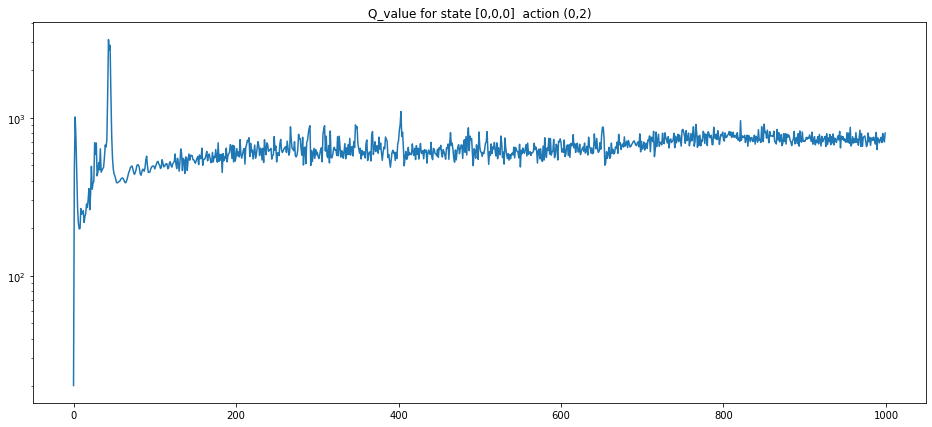

In [14]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

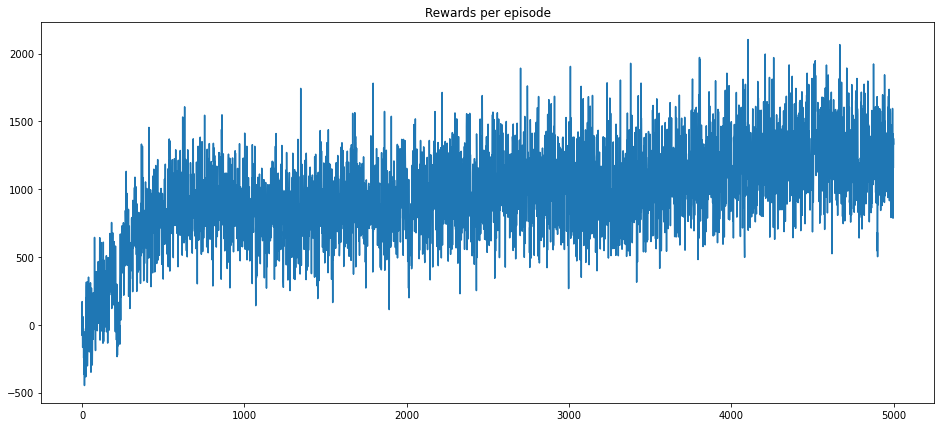

In [15]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(rewards_per_episode)))
plt.plot(xaxis,np.asarray(rewards_per_episode))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [16]:
time = np.arange(0,5000)
epsilon = []
for i in range(0,5000):
    epsilon.append(0 + (1 - 0.0001) * np.exp(-0.005*i))

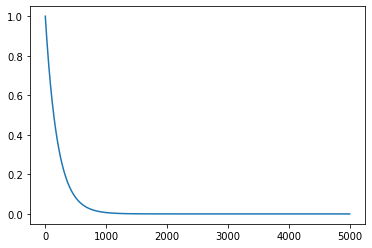

In [17]:
plt.plot(time, epsilon)
plt.show()